In [1]:
# Input info
# indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/clonal_shifts/mt_dendro/"
# se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simpleUnion/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"

# config
#N_DONORS = 2

clone_col="den_clust"
atac_col = "cluster_labels"

input_cond = "Input"

indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_init/dendro/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0/"
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_A2_black/se_cells_meta_labels.tsv" 
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/mt_as_clones_dendro/results/noInput/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0/"

N_DONORS = 2
condition = "noInput"


# params
min_clone_size = 2
p_thresh = 0.1 
n_cpus = 12


#conds_sep = False
n_shuffle = 1000



In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from src import clonal_shifts as cs


In [3]:
sep_dir = join(outdir,"sepDonors")
if not exists(sep_dir):
    os.mkdir(sep_dir)
donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
#     if not exists(join(donor_out[d], "shuffle")):
#         os.mkdir(join(donor_out[d], "shuffle"))
        
    

## Load data

In [4]:
#cells_dir=join(indir, "cells")
labels_df = pd.read_csv(se_cells_meta_f,sep="\t").set_index("ID")
print(labels_df.shape)
labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()

den_d = {}
for d in np.arange(N_DONORS):
    den_d[str(d)] = pd.read_csv(join(indir, f"don_{d}_mt_dendro_clust.csv"), index_col=0)

(18672, 41)
(16639, 41)


In [5]:
labels_df.head()

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,Row.names,index,raw.ID,new.index,condition,donor,donor_index,cluster_labels
ID,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAATCAGT-1_Control,Control,1972,1972,6432,1259,31,19,266,1066,3791,...,2211,1942,Control_AAACGAAAGAATCAGT-1,1.0,AAACGAAAGAATCAGT-1,2.0,Control,1,1.0,eosonophil
AAACGAAAGCATACCT-1_Control,Control,2674,2674,11858,1937,51,34,549,3102,6185,...,3311,2750,Control_AAACGAAAGCATACCT-1,2.0,AAACGAAAGCATACCT-1,3.0,Control,1,2.0,MPP/CMP/GMP C
AAACGAAAGCGAGAAA-1_Control,Control,1939,1939,7365,1097,25,27,275,2184,3757,...,2112,1838,Control_AAACGAAAGCGAGAAA-1,3.0,AAACGAAAGCGAGAAA-1,4.0,Control,0,2.0,MPP/CMP/GMP C
AAACGAAAGTACAGAT-1_Control,Control,862,862,4095,861,16,16,230,771,2201,...,1441,1317,Control_AAACGAAAGTACAGAT-1,4.0,AAACGAAAGTACAGAT-1,5.0,Control,0,3.0,erythroid
AAACGAAAGTACAGTA-1_Control,Control,1775,1775,8088,1091,27,27,369,2157,4417,...,2385,2085,Control_AAACGAAAGTACAGTA-1,5.0,AAACGAAAGTACAGTA-1,6.0,Control,1,3.0,eosonophil


In [6]:
labels_df["condition"]

ID
AAACGAAAGAATCAGT-1_Control    Control
AAACGAAAGCATACCT-1_Control    Control
AAACGAAAGCGAGAAA-1_Control    Control
AAACGAAAGTACAGAT-1_Control    Control
AAACGAAAGTACAGTA-1_Control    Control
                               ...   
TTTGTGTGTTTCTTAC-1_Input        Input
TTTGTGTTCCTGAAAC-1_Input        Input
TTTGTGTTCGGGAAAC-1_Input        Input
TTTGTGTTCGGGACAA-1_Input        Input
TTTGTGTTCTGGCACG-1_Input        Input
Name: condition, Length: 16639, dtype: object

## Filter for condition

In [7]:

if condition == "inputOnly":
    labels_df = labels_df[labels_df["condition"]==input_cond]
    for d in den_d:
        den_d[d] = den_d[d].loc[den_d[d]["condition"]==input_cond]
elif condition == "noInput":
    labels_df = labels_df[labels_df["condition"]!=input_cond]
    for d in den_d:
        den_d[d] = den_d[d].loc[den_d[d]["condition"]!=input_cond]
else:
    raise ValueError("condition not accurate")

# for d in den_d:
#     den_d[d] = den_d[d].loc[den_d[d].index.isin(labels_df.index)]

In [8]:
den_d[d].head()

,Donor,den_clust,condition
CAGGGCTGTCGTAGTT-1_Control,1,1_C9,Control
CGCTATCGTCAAACAA-1_Control,1,1_C7,Control
GTAGTACCATGATTGC-1_Control,1,1_C2,Control
CTCTCGATCGCACCTT-1_Control,1,1_C5,Control
CTTGAAGTCTGAGTAC-1_Control,1,1_C7,Control


## Create groups 

In [12]:
data = pd.merge(left=labels_df[[atac_col]], right=den_d[d], left_index=True, right_index=True, how='inner')
data

,cluster_labels,Donor,den_clust,condition
AAACGAAAGAATCAGT-1_Control,eosonophil,1,1_C5,Control
AAACGAAAGCATACCT-1_Control,MPP/CMP/GMP C,1,1_C2,Control
AAACGAAAGTACAGTA-1_Control,eosonophil,1,1_C2,Control
AAACGAAAGTGTCGGA-1_Control,erythroid,1,1_C5,Control
AAACGAAGTCTTAGCA-1_Control,erythroid,1,1_C5,Control
...,...,...,...,...
TTTGGTTGTGTTGGTT-1_Flt3l,eosonophil,1,1_C0,Flt3l
TTTGGTTGTTCTACGA-1_Flt3l,neutrophil,1,1_C2,Flt3l
TTTGGTTTCAGTCACA-1_Flt3l,MPP/CMP/GMP,1,1_C2,Flt3l
TTTGGTTTCGGTAGGA-1_Flt3l,neutrophil,1,1_C2,Flt3l


donor 0
Running hypergeo and saving sig results
plotting counts
Running hypergeo shuffle and saving sig results


Process ForkPoolWorker-4:
Process ForkPoolWorker-11:
Process ForkPoolWorker-2:
Process ForkPoolWorker-10:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/multiprocessing/

  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/mnt/md0/isshamie/Projects/Mito_Trace/src/clonal_shifts.py", line 45, in run_hypergeo
    n = groups[groups[clone_col] == cl]["count"].sum()
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/mnt/md0/isshamie/Projects/Mito_Trace/src/clonal_shifts.py", line 188, in wrap_create_enrichment
    clones=clones, atac_cl=atac_cl, to_correct=to_p_correct))
  File "/mnt/md0/isshamie/Projects/Mito_Trace/src/utils/parallel_helper.py", line 20, in multi_run_wrapper
    return curr_func(args[1], *args[2])
  File "/mnt/md0/isshamie/Projects/Mito_Trace/src/utils/parallel_helper.py", line 20, in multi_run_wrapper
    return curr_func(args[1], *arg

  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/arraylike.py", line 32, in __eq__
    return self._cmp_method(other, operator.eq)
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/frame.py", line 3427, in __getitem__
    return self._get_item_cache(key)
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/arraylike.py", line 32, in __eq__
    return self._cmp_method(other, operator.eq)
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/series.py", line 5514, in _logical_method
    return self._construct_result(res_values, name=res_name)
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/frame.py", line 3427, in __getitem__
    return self._get_item_cache(key)
  File "/mnt/md0/isshamie/Projects/Mito_Trace/src/clonal_shifts.py", line 74, in create_enrichment
    enrichment_df = run_hypergeo(groups, clones, atac_cl, atac_col

  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/generic.py", line 3616, in take
    indices, axis=self._get_block_manager_axis(axis), verify=True
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/generic.py", line 10434, in _min_count_stat_function
    min_count=min_count,
KeyboardInterrupt
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/nanops.py", line 93, in _f
    return f(*args, **kwargs)
KeyboardInterrupt
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 1549, in __init__
    if fastpath is not lib.no_default:
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/internals/blocks.py", line 1875, in maybe_coerce_values
    values = extract_array(values, extract_numpy=True)
KeyboardInterrupt
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/internals/ma

Traceback (most recent call last):
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4124580/3133119042.py", line 29, in <module>
    n_cpus=n_cpus)
  File "/mnt/md0/isshamie/Projects/Mito_Trace/src/clonal_shifts.py", line 446, in run_data_and_shuffle
    to_parallel=True, n_cpus=n_cpus)
  File "/mnt/md0/isshamie/Projects/Mito_Trace/src/clonal_shifts.py", line 205, in shuffle_hypergeo
    func_args=(groups, atac_col, clone_col, p_thresh, clones, atac_cl, to_p_correct),num_processes=n_cpus, to_flat=False)
  File "/mnt/md0/isshamie/Projects/Mito_Trace/src/utils/parallel_helper.py", line 53, in parallel_ar
    itertools.repeat(func_args)))
  File "/home/isaac/miniconda3/envs/mttrace/lib/python3.7/multiprocessing/pool.py", line 268, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/home/isaac/minicond

TypeError: object of type 'NoneType' has no len()

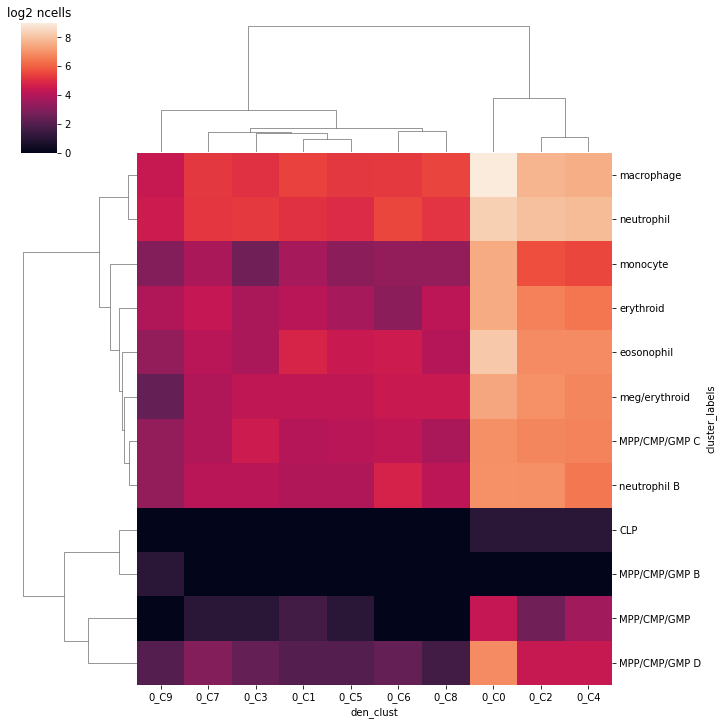

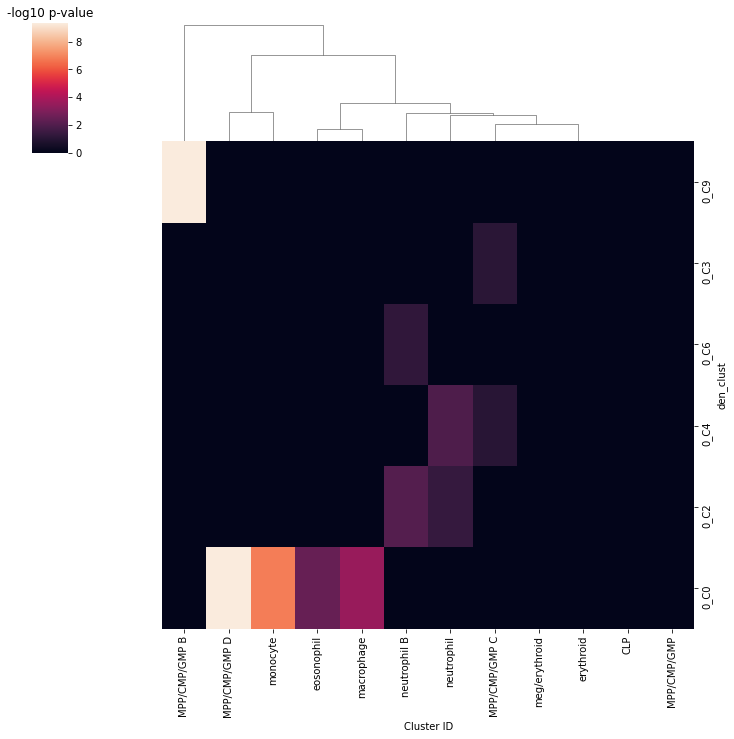

In [10]:
clone_col="den_clust"
atac_col = "cluster_labels"

for d in np.arange(N_DONORS):
    print("donor", d)
    d = str(d)
    curr_don_out = donor_out[int(d)]
    
    labels = labels_df[labels_df["donor"] == d]
    data = pd.merge(left=labels[[atac_col]], right=den_d[d], left_index=True, right_index=True)
    data = data.loc[~(data["cluster_labels"].isnull())]
    groups = data.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    name_cond_size = groups.groupby([clone_col]).size()
    name_cond_size = name_cond_size[name_cond_size>min_clone_size]
    clones_filt = name_cond_size.index
    sizes = data.groupby(clone_col).size().sort_values(ascending=False)
    sizes = sizes.loc[clones_filt].sort_values(ascending=False)
    clones = clones_filt.values #np.unique(groups["name"])
    clone_map = {x:ind for ind,x in enumerate(clones)}
    atac_cl = np.unique(groups[atac_col])

    # Run init hypergeo
    cs.hypergeo_plots(groups, clones, atac_cl, sizes, p_thresh, atac_col,
                   clone_col, curr_don_out)
    # RUN shuffle
    print("Running hypergeo shuffle and saving sig results")
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(groups, curr_don_out, atac_col, clone_col, p_thresh, clones, 
                                                      atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)    
    
    
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,
#                                                          p_thresh=p_thresh, atac_col=atac_col, 
#                                                           clone_col=clone_col)
    

#     don_out = donor_out[int(d)]
#     bh_enrichment_df.to_csv(join(don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     plt.savefig(join(don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
    
#     init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
#                                               clones=clones, atac_cl=atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=24)

#     results_df, out_d = cs.get_out(shuffle, clones, init_bh_enrichment, p_thresh, 
#                                                           clone_map, atac_col, 
#                                                           outdir=join(don_out, "shuffle"),figs_close=False)
    
    
#     # plot just the counts
#     groups["log2_count"] = np.log2(groups["count"]+1)
#     g = sns.clustermap(groups.pivot(index="cluster_labels",columns="den_clust", values="log2_count").fillna(0))
#     plt.gca().set_title("log2 ncells")
#     plt.savefig(join(don_out, "ncells.png"))
    
# groups

In [ ]:
results_df

In [ ]:
# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)

In [ ]:
# cell_pairs = []
# for ind,val in groups.iterrows():
#     cell_pairs.extend([[val["cluster_labels"], val["den_clust"]]]*val["count"])

# cell_pairs = np.array(cell_pairs)

# cell_pairs[:,1] = np.random.choice(cell_pairs[:,1], size= cell_pairs.shape[0],replace=False)
# cell_pairs

# grous_shuff = pd.DataFrame(cell_pairs,columns=[atac_col, clone_col]).groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
# grous_shuff

In [ ]:
# def get_out(shuffle, clones, bh_enrichment_df, p_thresh, clone_map, atac_col, outdir, figs_close=False):
#     global_min, clone_min, global_all, clone_all = cs.get_shuffle_results(shuffle, clones, clone_map=clone_map)
#     out_all = cs.plot_glob_all(bh_enrichment_df, global_all, p_thresh, atac_col=atac_col, out_f=join(outdir, "shuffle_all.png"))
#     out_min = cs.plot_glob_min(bh_enrichment_df, global_min, p_thresh, atac_col=atac_col, out_f=join(outdir, "shuffle_min.png"))
#     out_cloneall = cs.plot_clone_all(bh_enrichment_df, clone_all, p_thresh, out_f=join(outdir, "shuffle_cloneMin.png"))
#     out_clonemin = cs.plot_clone_min(bh_enrichment_df, clone_min, p_thresh=p_thresh, out_f=join(outdir, "shuffle_cloneAll.png"))
#     if figs_close:
#         plt.close('all')
#     # save results df with p-vals for each
#     #results_df = pd.concat((out_all[1].melt(), out_min[1].melt(), out_cloneall[1].melt(), out_clonemin[1].melt()))
#     results_df = pd.concat((out_all[1].melt().assign(method="global_all"),out_min[1].melt().assign(method="global_min"),
#                             out_cloneall[1].melt().assign(method="clone_all"),
#                             out_clonemin[1].melt().assign(method="clone_min")),
#                            axis=0)
#     import pickle
#     out_d = {"sig_all":out_all, "sig_min":out_min,
#              "sig_cloneAll": out_cloneall, "sig_cloneMin": out_clonemin}
#     pickle.dump(out_d, open(join(outdir, "shuffle_results.p"), "wb"))
#     results_df.to_csv(join(outdir, "shuffle_results_pvals.tsv"),sep="\t")
#     return results_df, out_d


# results_df, out_d = get_out(shuffle, clones, init_bh_enrichment, p_thresh, 
#                                                       clone_map, atac_col, 
#                                                       outdir=join(don_out, "shuffle"))

In [ ]:
# for curr_don, don_lin_mt_ncells in lin_mt_ncells.groupby("donor"):
#     curr_don_mt = don_lin_mt_ncells.set_index(["cluster_labels","donor"])
#     #lin_mt_ncells_w = curr_don_mt.reset_index().melt(id_vars=["cluster_labels", "donor"], var_name="Variant", value_name="ncells")
#     don_lin_mt_ncells_df = don_lin_mt_ncells.pivot(index="cluster_labels", columns="Variants", values="ncells" )
#     sns.clustermap(don_lin_mt_ncells_df.fillna(0))